In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.filters import gaussian

from skimage.morphology import skeletonize

from skimage.exposure import rescale_intensity

from skimage.measure import label, regionprops, find_contours

/Users/kuanlin/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


### Helper Functions

In [2]:
def dist(x1, y1, x2, y2):
    """Return the euclidean distance."""
    return np.sqrt((x1-x2)**2+(y1-y2)**2)

def contour_length(data):
    """Calculate the sum of the contour length."""
    val = 0
    for i in range(len(data)):
        if i != len(data) - 1:
            val += dist(data[i, 0], data[i, 1], data[i+1, 0], data[i+1, 1])
    return (val/2) # 1 pixel = 0.17 um

def pad_image(image):
    """Pad the image to avoid issue in skeletonizing."""
    padded = np.zeros(shape=(image.shape[0]+2, image.shape[1]+2), dtype = np.uint16)
    padded[1:image.shape[0]+1, 1:image.shape[1]+1] = image
    return padded

def check_branch(image, x, y):
    """Check if a pixel is the branching point."""
    VAL = 0
    for i in (x-1, x, x+1):
        for j in (y-1, y, y+1):
            if (i == x) and (j == y):
                continue
            else:
                VAL += image[i, j]
    if VAL > 2:
        return True
    else:
        return False
    
def checker(tube):
    """Check if a tube is branched."""
    # blur the padded image to denoise
    blurred = gaussian(pad_image(tube.image))
    # skeletonize the tube
    candidate = skeletonize(blurred > blurred.mean())
    # travel along the tube and check if branched
    x, y = candidate.shape
    for i in range(1, x-1):
        for j in range(1, y-1):
            if candidate[i, j] and check_branch(candidate, i, j):
                return True
    return False

In [3]:
def seed_identification(img):
    """
    Identify the seeds in the image.
    
    Parameters:
        img (np.array): image of the seed.
        
    Returns:
        seed_list (list): a list of the seed objects.   
    """
    # Create binary mask
    binary = img > (img.mean() + 2 * img.std())
    # Identify connected blobs
    label_im = label(binary)
    seed_list = regionprops(label_im)
    # Remove small blobs
    seed_list = [i for i in seed_list if i.area > 5]
    return seed_list

def seeded_tube_identification(img, seeds):
    """
    Identify the tubes in the image. Note that branched structures are removed.
    
    Parameters:
        img (np.array): image of the tube.
        
        seeds (list): list of the seeds.
        
    Returns:
        seeded_tubes (list): a list of the seeded tube objects.
        
        unseeded_tubes (list): a list of the unseeded tube objects.
    """
    # Create binary mask
    binary = img > (img.mean() + 2 * img.std())
    # Identify connected blobs
    label_im = label(binary)
    tube_list = regionprops(label_im)
    # Remove small and branched structures
    tube_list = [i for i in tube_list if i.area > 10 and checker(i) == False]
    seeded_tubes, unseeded_tubes = [], []
    # Create seed location map
    seed_map = np.zeros_like(binary)
    for seed in seeds:
        minr, minc, maxr, maxc = seed.bbox
        seed_map[minr:maxr,minc:maxc] = 1
    # Identify which tubes contains seeds
    for tube in tube_list:
        minr, minc, maxr, maxc = tube.bbox
        if np.sum(seed_map[minr:maxr, minc:maxc]) > 0:
            seeded_tubes.append(tube)
        else:
            unseeded_tubes.append(tube)
    return seeded_tubes, unseeded_tubes

def tube_length_analysis(tube):
    """
    Measure the length of the tube through the tube contour.
    
    Parameters:
        tube: the tube object.
    Returns:
        val (float): the length of the tube, unit: pixel.
    """
    # blur the padded image to denoise 
    blurred = gaussian(pad_image(tube.image))
    # Create a binary mask
    candidate = skeletonize(blurred > blurred.mean())
    # Find thr contour
    contours = find_contours(candidate, .5, fully_connected = 'high')
    # Start counting
    val = 0
    for contour in contours:
        val += contour_length(contour)
    return val

## Example - Individual Files as Input

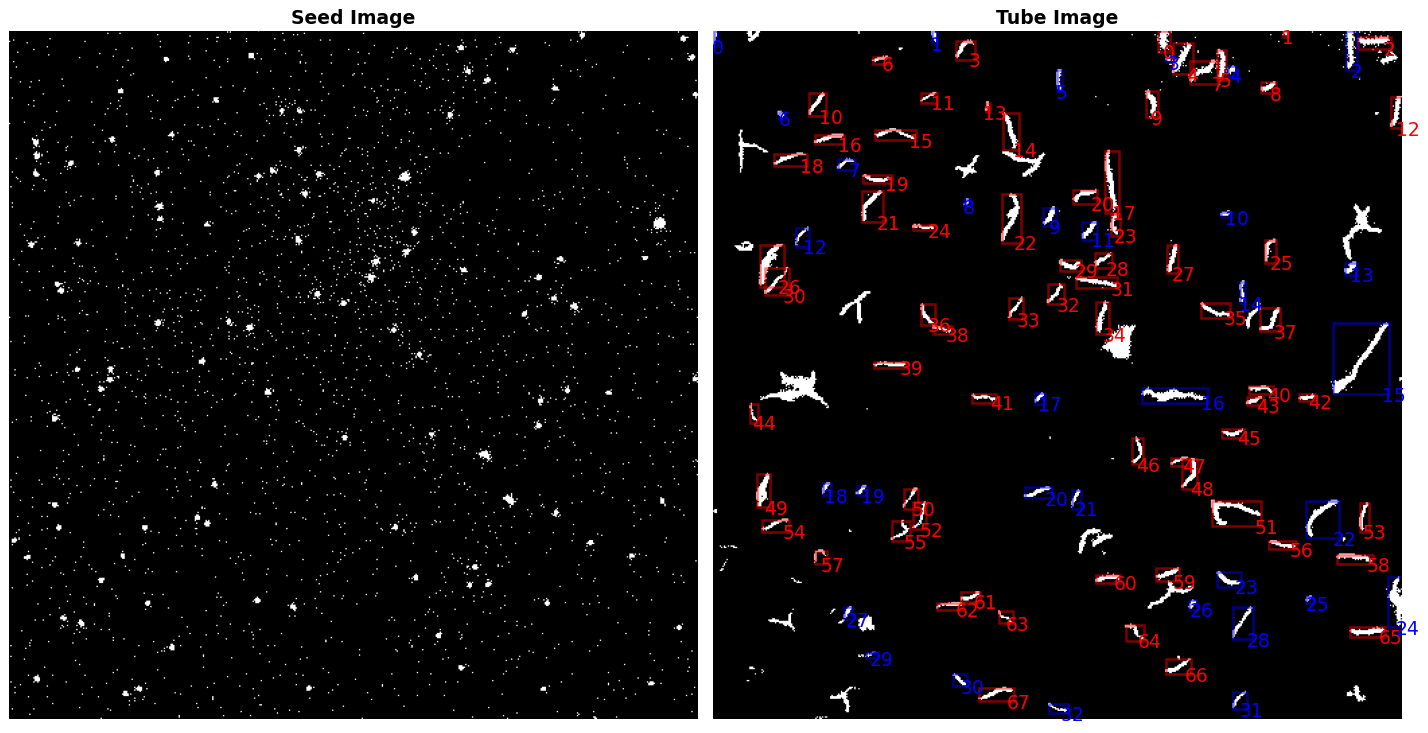

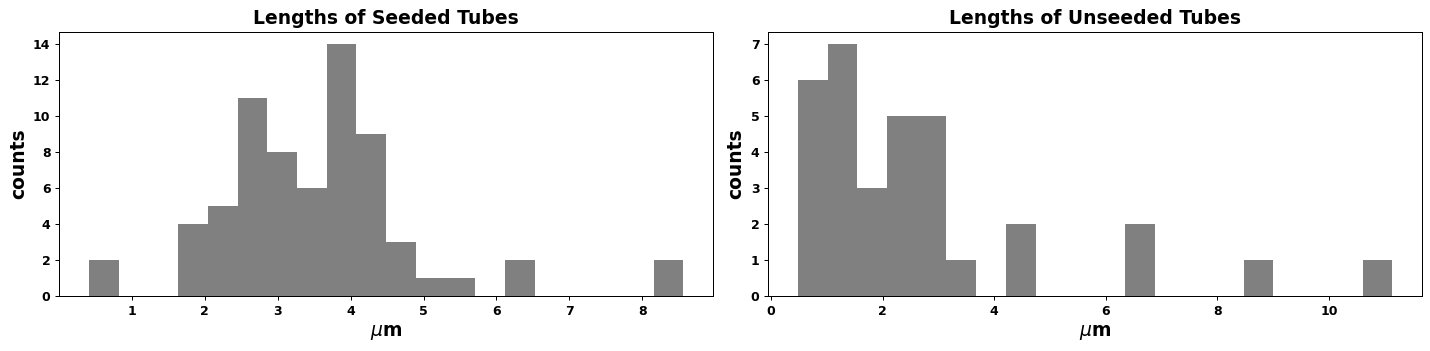

In [4]:
#########
# PARAM #
#########

# Load in images
seed_img = plt.imread('./Sample Data/1A.tif')
tube_img = plt.imread('./Sample Data/1B.tif')
filenames = ('./Sample Data/1-seeded-tubes.csv', './Sample Data/1-unseeded-tubes.csv')

#########
# START #
#########

# Identify the seed
seed_list = seed_identification(seed_img)

# Identify seeded and unseeded tubes
seeded_tubes, unseeded_tubes = seeded_tube_identification(tube_img, seed_list)

# Create the dataframe (Excel sheet) for the tubes
seeded_tube_length = []
for i in range(len(seeded_tubes)):
    seeded_tube_length.append(tube_length_analysis(seeded_tubes[i]))
unseeded_tube_length = []
for i in range(len(unseeded_tubes)):
    unseeded_tube_length.append(tube_length_analysis(unseeded_tubes[i]))
    
seeded_tube_df = pd.DataFrame({"id": range(len(seeded_tubes)),
                               "length (px)": seeded_tube_length,
                               "length (um)": [val*0.17 for val in seeded_tube_length]})

unseeded_tube_df = pd.DataFrame({"id": range(len(unseeded_tubes)),
                                 "length (px)": unseeded_tube_length,
                                 "length (um)": [val*0.17 for val in unseeded_tube_length]})

# Tube Visualization
figure = plt.figure(figsize=(16, 8), dpi = 90)
plt.subplot(1, 2, 1)
plt.title("Seed Image", fontsize = 15, weight = 'bold')
p2, p98 = np.percentile(seed_img, (2, 98))
img_rescale = rescale_intensity(seed_img, in_range=(p2, p98))
plt.imshow(seed_img > (seed_img.mean() + 2 * seed_img.std()), cmap = "gray")
plt.axis(False)

ax = plt.subplot(1, 2, 2)
plt.title("Tube Image", fontsize = 15, weight = 'bold')
p2, p98 = np.percentile(tube_img, (2, 98))
img_rescale = rescale_intensity(tube_img, in_range=(p2, p98))
plt.imshow(tube_img > (tube_img.mean() + 2 * tube_img.std()), cmap = "gray")

# Plot seeded tubes
for i in range(len(seeded_tubes)):
    minr, minc, maxr, maxc = seeded_tubes[i].bbox
    rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2, alpha=.5)
    ax.add_patch(rect)
    ax.text(maxc - 5, maxr + 5, str(i), color = 'red', fontsize = 15)
    
# Plot unseeded tubes
for i in range(len(unseeded_tubes)):
    minr, minc, maxr, maxc = unseeded_tubes[i].bbox
    rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='blue', linewidth=2, alpha=.5)
    ax.add_patch(rect)
    ax.text(maxc - 5, maxr + 5, str(i), color = 'blue', fontsize = 15)
    
plt.axis(False)

plt.tight_layout()
plt.show()

# Length Distribution
figure = plt.figure(figsize=(16, 4), dpi = 90)

plt.subplot(1, 2, 1)

plt.hist(seeded_tube_df["length (um)"], bins = 20, color = "gray")
plt.title("Lengths of Seeded Tubes", fontsize = 15, weight = 'bold')
plt.xticks(fontsize = 10, weight = 'bold')
plt.yticks(fontsize = 10, weight = 'bold')
plt.xlabel("$\mu$m", fontsize = 15, weight = 'bold')
plt.ylabel("counts", fontsize = 15, weight = 'bold')

plt.subplot(1, 2, 2)
plt.hist(unseeded_tube_df["length (um)"], bins = 20, color = "gray")
plt.title("Lengths of Unseeded Tubes", fontsize = 15, weight = 'bold')
plt.xticks(fontsize = 10, weight = 'bold')
plt.yticks(fontsize = 10, weight = 'bold')
plt.xlabel("$\mu$m", fontsize = 15, weight = 'bold')
plt.ylabel("counts", fontsize = 15, weight = 'bold')

plt.tight_layout()
plt.show()

# Save data to CSV files
seeded_tube_df.to_csv(filenames[0], index=False)
unseeded_tube_df.to_csv(filenames[1], index=False)

## Example - Folder as Input

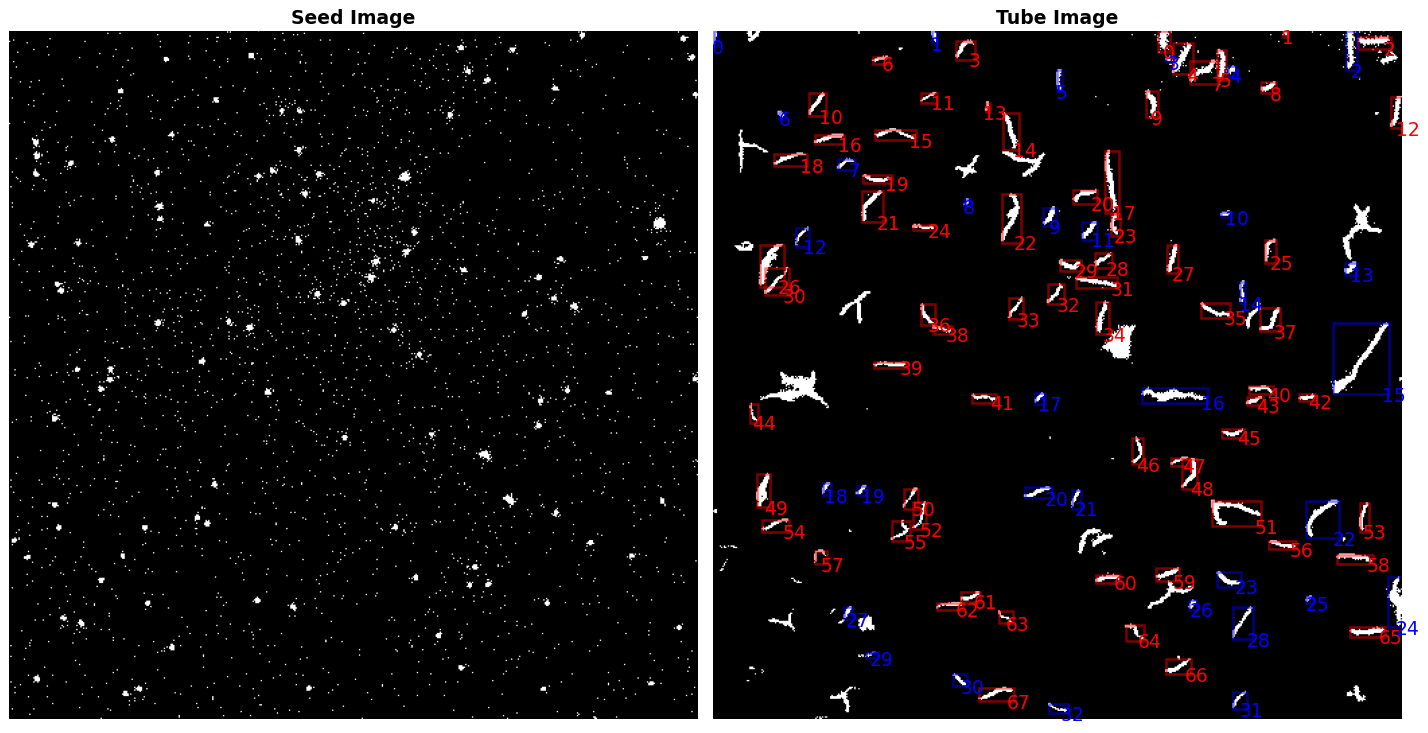

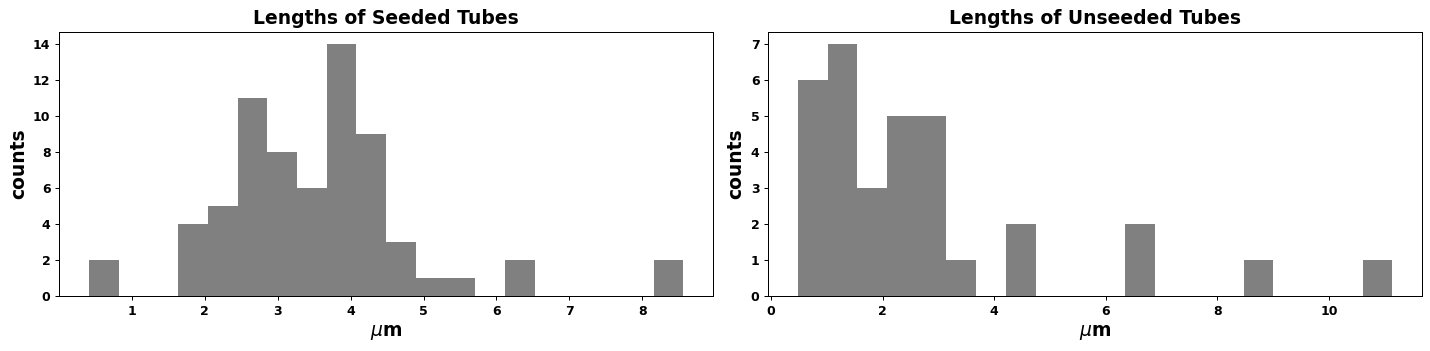

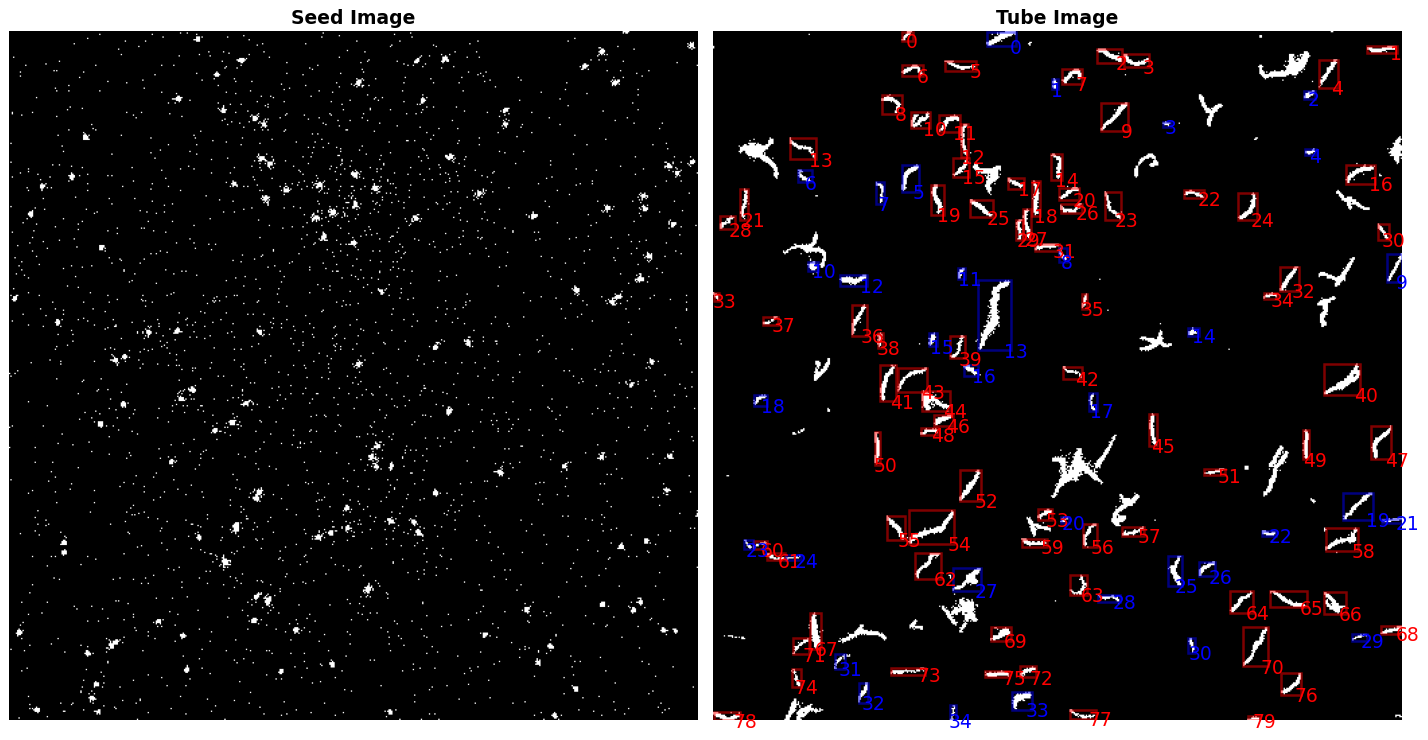

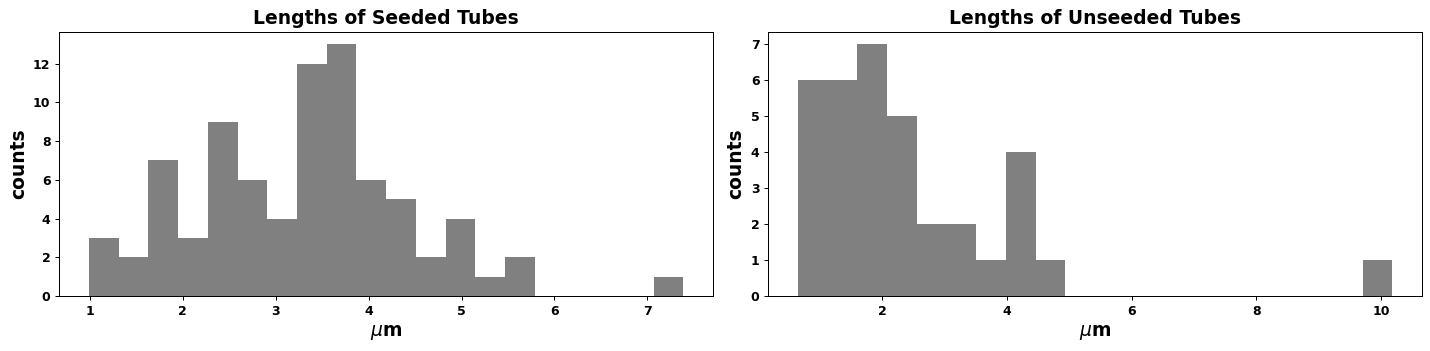

In [5]:
#########
# PARAM #
#########

# Folder

foldername = "./Sample Data/"
num = 2

#########
# START #
#########

seeded_tube_df_master = pd.DataFrame()
unseeded_tube_df_master = pd.DataFrame()

for n in range(num):
    # Load in images
    seed_img = plt.imread(foldername+'{:.0f}A.tif'.format(n+1))
    tube_img = plt.imread(foldername+'{:.0f}B.tif'.format(n+1))
    filenames = (foldername+'{:.0f}-seeded-tubes.csv'.format(n+1), foldername+'{:.0f}-unseeded-tubes.csv'.format(n+1))
    
    # Identify the seed
    seed_list = seed_identification(seed_img)

    # Identify seeded and unseeded tubes
    seeded_tubes, unseeded_tubes = seeded_tube_identification(tube_img, seed_list)

    # Create the dataframe (Excel sheet) for the tubes
    seeded_tube_length = []
    for i in range(len(seeded_tubes)):
        seeded_tube_length.append(tube_length_analysis(seeded_tubes[i]))
    unseeded_tube_length = []
    for i in range(len(unseeded_tubes)):
        unseeded_tube_length.append(tube_length_analysis(unseeded_tubes[i]))

    seeded_tube_df = pd.DataFrame({"id": range(len(seeded_tubes)),
                                   "length (px)": seeded_tube_length,
                                   "length (um)": [val*0.17 for val in seeded_tube_length]})

    unseeded_tube_df = pd.DataFrame({"id": range(len(unseeded_tubes)),
                                     "length (px)": unseeded_tube_length,
                                     "length (um)": [val*0.17 for val in unseeded_tube_length]})

    # Tube Visualization
    figure = plt.figure(figsize=(16, 8), dpi = 90)
    plt.subplot(1, 2, 1)
    plt.title("Seed Image", fontsize = 15, weight = 'bold')
    p2, p98 = np.percentile(seed_img, (2, 98))
    img_rescale = rescale_intensity(seed_img, in_range=(p2, p98))
    plt.imshow(seed_img > (seed_img.mean() + 2 * seed_img.std()), cmap = "gray")
    plt.axis(False)

    ax = plt.subplot(1, 2, 2)
    plt.title("Tube Image", fontsize = 15, weight = 'bold')
    p2, p98 = np.percentile(tube_img, (2, 98))
    img_rescale = rescale_intensity(tube_img, in_range=(p2, p98))
    plt.imshow(tube_img > (tube_img.mean() + 2 * tube_img.std()), cmap = "gray")

    # Plot seeded tubes
    for i in range(len(seeded_tubes)):
        minr, minc, maxr, maxc = seeded_tubes[i].bbox
        rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2, alpha=.5)
        ax.add_patch(rect)
        ax.text(maxc - 5, maxr + 5, str(i), color = 'red', fontsize = 15)

    # Plot unseeded tubes
    for i in range(len(unseeded_tubes)):
        minr, minc, maxr, maxc = unseeded_tubes[i].bbox
        rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='blue', linewidth=2, alpha=.5)
        ax.add_patch(rect)
        ax.text(maxc - 5, maxr + 5, str(i), color = 'blue', fontsize = 15)

    plt.axis(False)

    plt.tight_layout()
    plt.show()

    # Length Distribution
    figure = plt.figure(figsize=(16, 4), dpi = 90)

    plt.subplot(1, 2, 1)

    plt.hist(seeded_tube_df["length (um)"], bins = 20, color = "gray")
    plt.title("Lengths of Seeded Tubes", fontsize = 15, weight = 'bold')
    plt.xticks(fontsize = 10, weight = 'bold')
    plt.yticks(fontsize = 10, weight = 'bold')
    plt.xlabel("$\mu$m", fontsize = 15, weight = 'bold')
    plt.ylabel("counts", fontsize = 15, weight = 'bold')

    plt.subplot(1, 2, 2)
    plt.hist(unseeded_tube_df["length (um)"], bins = 20, color = "gray")
    plt.title("Lengths of Unseeded Tubes", fontsize = 15, weight = 'bold')
    plt.xticks(fontsize = 10, weight = 'bold')
    plt.yticks(fontsize = 10, weight = 'bold')
    plt.xlabel("$\mu$m", fontsize = 15, weight = 'bold')
    plt.ylabel("counts", fontsize = 15, weight = 'bold')

    plt.tight_layout()
    plt.show()

    # Save data to CSV files
    seeded_tube_df.to_csv(filenames[0], index=False)
    unseeded_tube_df.to_csv(filenames[1], index=False)
    
    # Append to master csv
    seeded_tube_df["img"] = n+1
    unseeded_tube_df["img"] = n+1
    seeded_tube_df_master = pd.concat((seeded_tube_df_master, seeded_tube_df))
    unseeded_tube_df_master = pd.concat((unseeded_tube_df_master, unseeded_tube_df))
    
seeded_tube_df_master.to_csv(foldername+"all-seeded-tubes.csv", index=False)
unseeded_tube_df_master.to_csv(foldername+"all-unseeded-tubes.csv", index=False)
